# Text Classification (Machine Learning)
# Klasifikasi SMS Spam Berbahasa Indonesia Menggunakan Metode Multinomial Naive Bayes & Feature Selection Chi-Square dan Deploy menggunakan Gradio
---
Berikut untuk Skema nya

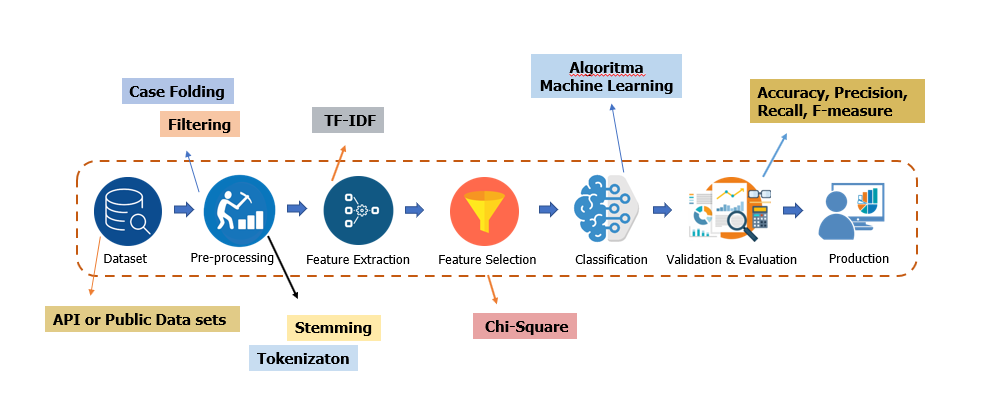

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [696]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [697]:
# Install library Sastrawi
# !pip -q install sastrawi

In [698]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 01 Data Acquisition

Penjelasan Label 
* 0: SMS normal 
* 1: SMS fraud atau penipuan 
* 2: SMS promo

In [699]:
# Download dataset
# !wget 

In [700]:
data = pd.read_csv('data/dataset_sms_spam_v1.csv')
data.head()

,teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [701]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1143 non-null   object
 1   label   1143 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.0+ KB


In [702]:
print('Total Jumlah SMS:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] SMS Normal\t:', data[data.label == 0].shape[0], 'data')
print('-- [1] Fraud / Penipuan\t:', data[data.label == 1].shape[0], 'data')
print('-- [2] Promo\t\t:', data[data.label == 2].shape[0], 'data\n')

Total Jumlah SMS: 1143 data

terdiri dari (label):
-- [0] SMS Normal	: 569 data
-- [1] Fraud / Penipuan	: 335 data
-- [2] Promo		: 239 data



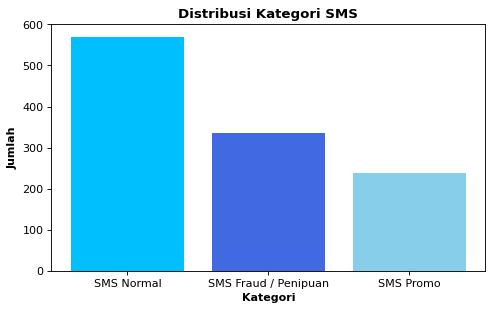

In [703]:
height = data['label'].value_counts()
labels = ('SMS Normal', 'SMS Fraud / Penipuan', 'SMS Promo')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Kategori SMS', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# 02 Text Preprocessing

## Case Folding

In [704]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [705]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding	:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel


## Word Normalization

In [706]:
# Download corpus kumpulan slangwords
# !wget 

In [707]:
key_norm = pd.read_csv('data/key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [708]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [709]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [710]:
len(stopwords_ind)

758

In [711]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [712]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['tsel', 'gb', 'rb']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [713]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel


## Stemming

In [714]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [715]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case folding		:  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword removal	:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel
Stemming		:  ekstra pulsa dg beli paket internet bulan mytelkomsel utk beli sjk augsept cek detail promo tselmemytsel


## Text Preprocessing Pipeline

In [716]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [717]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: total: 1min 47s
Wall time: 4min 24s


In [718]:
data

,teks,label,clean_teks
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,promo beli paket flash my telkomsel app extra ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,rupiah ribu spesial pilih aktif promo sd novem...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,pulang hormat sisa kuota flash kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,rupiah ribu spesial pilih aktif buru skb
...,...,...,...
1138,"Yooo sama2, oke nanti aku umumin di grup kelas",0,yooo oke umumin grup kelas
1139,😁 sebelumnya ga ad nulis kerudung. Kirain warn...,0,nulis kerudung kirain warna jins
1140,Mba mau kirim 300 ya,0,mbak kirim ya
1141,nama1 beaok bwrangkat pagi...mau cas atay tra...,0,nama beaok bwrangkat pagimau cas atay tranfer


In [719]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('data/clean_data.csv')

# 03 Feature Engineering

In [720]:
# Pisahkan kolom fitur dan target
X = data['clean_teks']
y = data['label']

In [721]:
X

0       promo beli paket flash my telkomsel app extra ...
1       rupiah ribu spesial pilih aktif promo sd novem...
2       pulang hormat sisa kuota flash kb download myt...
3       pulang hormat sisa kuota flash kb download myt...
4                rupiah ribu spesial pilih aktif buru skb
                              ...                        
1138                           yooo oke umumin grup kelas
1139                     nulis kerudung kirain warna jins
1140                                        mbak kirim ya
1141        nama beaok bwrangkat pagimau cas atay tranfer
1142                                       nomor bri nama
Name: clean_teks, Length: 1143, dtype: object

In [722]:
y

0       2
1       2
2       2
3       2
4       2
       ..
1138    0
1139    0
1140    0
1141    0
1142    0
Name: label, Length: 1143, dtype: int64

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi vektor menggunakan metode BoW

In [723]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [724]:
# Melihat jumlah fitur
print(len(bow.get_feature_names_out()))

3253


In [725]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(bow.get_feature_names_out())

['aa' 'aamiiiin' 'aamiin' ... 'zjt' 'zona' 'ztkm']


In [726]:
# Melihat matriks jumlah fitur
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [727]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [728]:
with open('model/bow_feature.pickle', 'wb') as output:
  pickle.dump(X_bow, output)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [729]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [730]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

3253


In [731]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aamiiiin' 'aamiin' ... 'zjt' 'zona' 'ztkm']


In [732]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [733]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [734]:
with open('model/tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [735]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [736]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 

# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 3253
Reduced feature number: 1000


In [737]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.835608
1,0.419698
2,1.558607
3,0.716455
4,0.800674
...,...
3248,1.180239
3249,0.503162
3250,0.716455
3251,2.917381


In [738]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.835608,aa
1,0.419698,aamiiiin
2,1.558607,aamiin
3,0.716455,ab
4,0.800674,abadi
...,...,...
3248,1.180239,zalora
3249,0.503162,zarkasi
3250,0.716455,zjt
3251,2.917381,zona


In [739]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
2088,49.062970,paket
1030,46.324101,hadiah
1549,45.593560,kuota
2178,39.438431,pin
1486,34.448410,klik
...,...,...
1520,0.044910,kopi
307,0.044468,bca
1694,0.031579,maksimal
531,0.013783,cepat


In [740]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False,  True, ..., False,  True, False])

In [741]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
    if bool:
        new_feature.append(f)
    selected_feature = new_feature

selected_feature

['aamiin',
 'agam',
 'agen',
 'ags',
 'agst',
 'agsts',
 'agt',
 'agtskinfodlj',
 'agun',
 'agustuskunjungi',
 'ajak',
 'akses',
 'aktif',
 'aktivasi',
 'alam',
 'alamsyah',
 'aliando',
 'all',
 'aman',
 'amanda',
 'an',
 'anda',
 'andabch',
 'andika',
 'andromax',
 'angga',
 'angpaopoinsenyum',
 'angsur',
 'anrasto',
 'ap',
 'apa',
 'aplikasi',
 'app',
 'appleplay',
 'apps',
 'appsinapps',
 'argo',
 'armada',
 'artha',
 'artisartis',
 'arya',
 'as',
 'asa',
 'asli',
 'ass',
 'assalamualaikum',
 'at',
 'atas',
 'ato',
 'aug',
 'augsept',
 'avanza',
 'axiata',
 'axis',
 'axisnet',
 'ayah',
 'ayam',
 'ayo',
 'bagi',
 'baik',
 'bakmi',
 'balas',
 'ball',
 'bandung',
 'bandungmulai',
 'bang',
 'banget',
 'bank',
 'banting',
 'banyak',
 'bapa',
 'bareng',
 'barokahmp',
 'baru',
 'baruqskrng',
 'baskin',
 'batas',
 'batin',
 'bawa',
 'bayar',
 'bb',
 'bbm',
 'bch',
 'bebek',
 'beda',
 'belanja',
 'beli',
 'beliau',
 'belikan',
 'bentar',
 'berangkat',
 'beres',
 'berkat',
 'berlakupromo',
 '

In [742]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [743]:
kbest_feature

{'promo': 2295,
 'beli': 323,
 'paket': 2088,
 'flash': 870,
 'my': 1880,
 'telkomsel': 2875,
 'app': 162,
 'extra': 841,
 'kuota': 1549,
 'lte': 1652,
 'telpon': 2878,
 'mnthr': 1831,
 'buru': 480,
 'cek': 521,
 'tselmemytsel': 3013,
 'sk': 2691,
 'rupiah': 2503,
 'ribu': 2452,
 'spesial': 2750,
 'pilih': 2175,
 'aktif': 66,
 'sd': 2557,
 'november': 1989,
 'hormat': 1116,
 'sisa': 2684,
 'kb': 1410,
 'download': 752,
 'mytelkomsel': 1882,
 'apps': 167,
 'kuotabeli': 1550,
 'hubung': 1140,
 'skb': 2692,
 'ekstra': 804,
 'pulsa': 2332,
 'internet': 1220,
 'bulan': 466,
 'sjk': 2690,
 'augsept': 217,
 'detail': 665,
 'iring': 1242,
 'tarif': 2841,
 'panjang': 2101,
 'hits': 1105,
 'armada': 180,
 'curi': 600,
 'tekan': 2869,
 'okcall': 2041,
 'informasi': 1191,
 'eks': 801,
 'loh': 1639,
 'internetan': 1221,
 'pakai': 2086,
 'volume': 3129,
 'ultima': 3066,
 'mbhr': 1738,
 'harga': 1057,
 'tariflokasi': 2843,
 'tselmefl': 3011,
 'jr': 1329,
 'baru': 283,
 'noah': 1964,
 'nya': 2010,
 'h

In [744]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,agam,agen,ags,agst,agsts,agt,agtskinfodlj,agun,agustuskunjungi,...,yesok,your,yrkz,ytg,ythmohon,ythsaya,yuk,yunit,zalora,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [745]:
with open('model/kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning)

In [746]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [747]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [748]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model/model_1.pickle')

['model/model_1.pickle']

In [749]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([1, 2, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 1, 0, 2, 0, 0,
       1, 0, 1, 1, 0, 2, 0, 1, 2, 0, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 0, 2, 1, 0, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0,
       0, 0, 1, 2, 1, 0, 2, 0, 2, 2, 1, 2, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 0, 0,
       1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 2, 1, 0, 0], dtype=int64)

In [750]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array([1, 2, 0, 1, 1, 0, 0, 1, 2, 0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 2, 0, 2,
       1, 0, 1, 2, 0, 2, 1, 1, 2, 0, 2, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0, 1,
       0, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2,
       0, 0, 1, 1, 0, 2, 1, 2, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 0, 1, 0, 0,
       2, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0,
       1, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 0,
       0, 0, 1, 0, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 1, 1, 1, 0, 2, 1, 1, 2,
       1, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 2, 0, 2, 1, 0,
       1, 0, 0, 2, 1, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 2, 1, 0, 0], dtype=int64)

# 05 Model Evaluation

In [751]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 211
Jumlah prediksi salah	: 18
Akurasi pengujian	: 92.13973799126637 %


In [752]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[106   1   1]
 [  6  64   1]
 [  6   3  41]]


In [753]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       108
           1       0.94      0.90      0.92        71
           2       0.95      0.82      0.88        50

    accuracy                           0.92       229
   macro avg       0.93      0.90      0.91       229
weighted avg       0.92      0.92      0.92       229



In [754]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.91266376 0.89956332 0.930131   0.89956332 0.91266376 0.91266376
 0.94759825 0.89519651 0.89519651 0.89082969] 

Rata-rata akurasi pada cross validation: 0.9096069868995634


# 06 Simple Deployment


In [755]:
from joblib import load

# load model
model = load('model/model_1.pickle')

# load vocabulary dari TF_idf
vocab = pickle.load(open('model/kbest_feature.pickle', 'rb'))
vocab

{'promo': 2295,
 'beli': 323,
 'paket': 2088,
 'flash': 870,
 'my': 1880,
 'telkomsel': 2875,
 'app': 162,
 'extra': 841,
 'kuota': 1549,
 'lte': 1652,
 'telpon': 2878,
 'mnthr': 1831,
 'buru': 480,
 'cek': 521,
 'tselmemytsel': 3013,
 'sk': 2691,
 'rupiah': 2503,
 'ribu': 2452,
 'spesial': 2750,
 'pilih': 2175,
 'aktif': 66,
 'sd': 2557,
 'november': 1989,
 'hormat': 1116,
 'sisa': 2684,
 'kb': 1410,
 'download': 752,
 'mytelkomsel': 1882,
 'apps': 167,
 'kuotabeli': 1550,
 'hubung': 1140,
 'skb': 2692,
 'ekstra': 804,
 'pulsa': 2332,
 'internet': 1220,
 'bulan': 466,
 'sjk': 2690,
 'augsept': 217,
 'detail': 665,
 'iring': 1242,
 'tarif': 2841,
 'panjang': 2101,
 'hits': 1105,
 'armada': 180,
 'curi': 600,
 'tekan': 2869,
 'okcall': 2041,
 'informasi': 1191,
 'eks': 801,
 'loh': 1639,
 'internetan': 1221,
 'pakai': 2086,
 'volume': 3129,
 'ultima': 3066,
 'mbhr': 1738,
 'harga': 1057,
 'tariflokasi': 2843,
 'tselmefl': 3011,
 'jr': 1329,
 'baru': 283,
 'noah': 1964,
 'nya': 2010,
 'h

In [756]:
#@title Masukkan Teks Anda:
input_text = "Bisa Bayar Di Tempat. Kacang mede/mente asli Wonogiri. Stok selalu baru dan fress bukan stok lama. Sedia. Mentah utuh120rb. Matang 135rbu. Chat/wa 08229808xxxx." #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF
# tf_idf_vec
result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result==0):
  sms = 'SMS Normal'
elif (result==1):
  sms = 'SMS Fraud'
else:
  sms = 'SMS Promo'

print('Hasil prediksi', input_text, ' adalah\n', sms)

Hasil Text Preprocessing : bayar kacang medemente asli wonogiri stok fress stok sedia mentah utuhrb matang rbu chatwa xxxx
Hasil prediksi Bisa Bayar Di Tempat. Kacang mede/mente asli Wonogiri. Stok selalu baru dan fress bukan stok lama. Sedia. Mentah utuh120rb. Matang 135rbu. Chat/wa 08229808xxxx.  adalah
 SMS Fraud


In [757]:
import gradio as gr

In [758]:
import joblib
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
import gradio as gr

# Load the TF-IDF vectorizer using joblib
vocab = pickle.load(open('model/kbest_feature.pickle', 'rb'))

# Load the Naive Bayes model using pickle
with open('model/model_1.joblib', 'rb') as f:
    model = joblib.load(f)

def predict_klasifikasi(text):
    pre_input_text = text_preprocessing_process(text)
    # Transform the new text data using the loaded TF-IDF vectorizer
    tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab)) 
    pred = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi
    
    if pred == 0:
        return 'SMS Normal'
    elif pred == 1:
        return 'SMS Fraud'
    else:
        return 'SMS Promo'

# Create a Gradio interface
iface = gr.Interface(fn=predict_klasifikasi, inputs="text", outputs="text")

# Launch the interface
iface.launch()


Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.


# 07 WordCloud

In [760]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [761]:
# Download gambar masking
# !wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

In [762]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

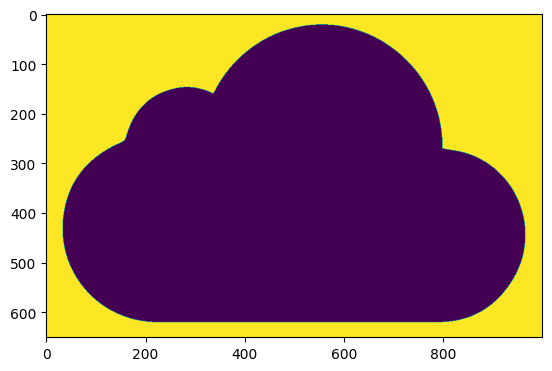

In [763]:
# Tampilkan masking
# from google.colab.patches import cv2_imshow

plt.imshow(cloud_mask)

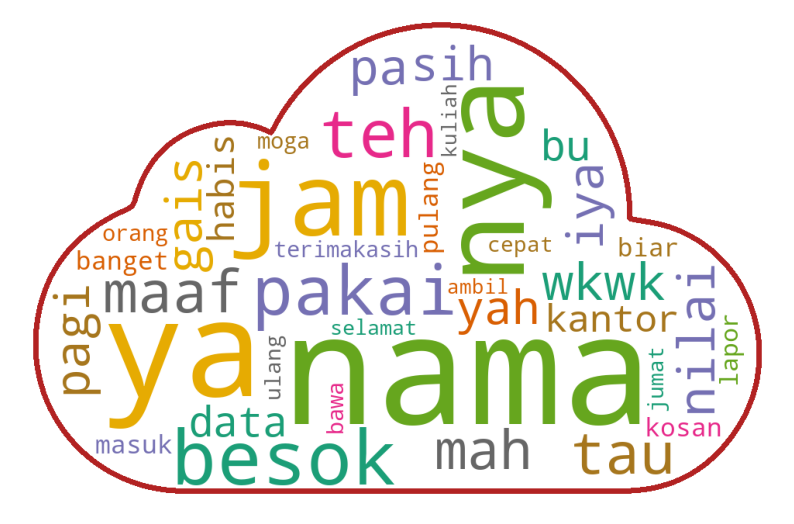

In [764]:
# WordCloud Label SMS Normal

sms_normal = data[data.label == 0]
normal_string = []

for t in sms_normal.clean_teks:
  normal_string.append(t)

normal_string = pd.Series(normal_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(normal_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

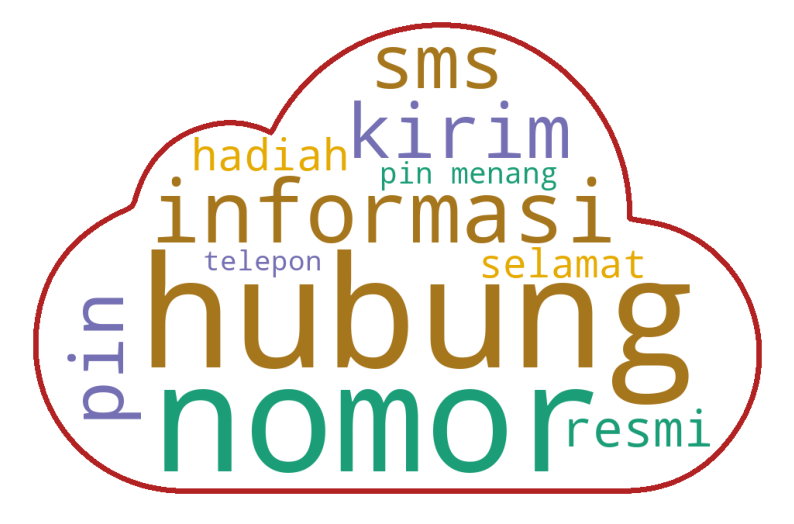

In [765]:
# WordCloud Label SMS Fraud / Penipuan

sms_fraud = data[data.label == 1]
fraud_string = []

for t in sms_fraud.clean_teks:
  fraud_string.append(t)

fraud_string = pd.Series(fraud_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(fraud_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

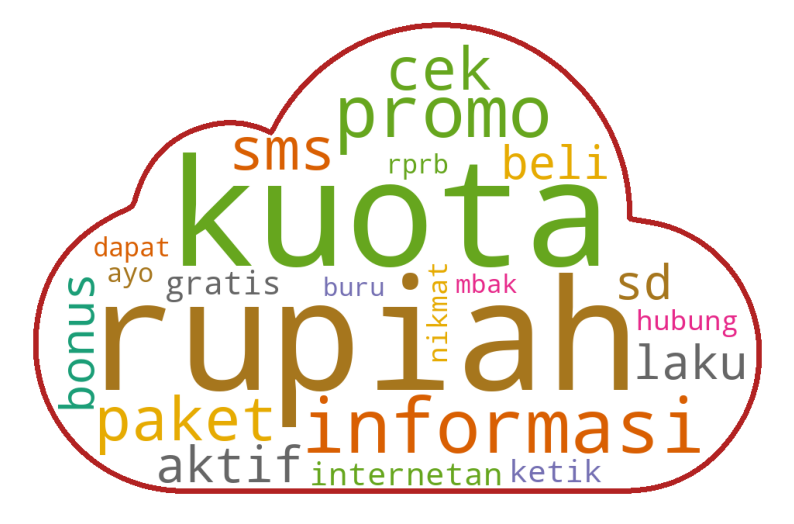

In [766]:
# WordCloud Label SMS Promo

sms_promo = data[data.label == 2]
promo_string = []

for t in sms_promo.clean_teks:
  promo_string.append(t)

promo_string = pd.Series(promo_string).str.cat(sep=' ')
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(promo_string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()